In [12]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# PyG install that adapts to your torch+cuda version
import torch, re
torch_ver = torch.__version__.split('+')[0]
cuda_ver = torch.version.cuda
cuda_tag = "cpu" if cuda_ver is None else f"cu{cuda_ver.replace('.','')}"
whl = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html"

!pip -q install torch-geometric -f {whl}


from google.colab import drive
drive.mount('/content/drive')

ROOT = "/content/drive/MyDrive/QC"
RGB_DIR  = f"{ROOT}/rgb"
MASK_DIR = f"{ROOT}/mask"
CSV_DIR  = f"{ROOT}/csv"
SPLIT_DIR= f"{ROOT}/train_test_splits"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob
import pandas as pd

ROOT = "/content/drive/MyDrive/QC"
RGB_DIR   = f"{ROOT}/rgb"
CSV_DIR   = f"{ROOT}/csv"
SPLIT_DIR = f"{ROOT}/train_test_splits"

IMG_EXTS = ["png","jpg","jpeg","tif","tiff"]

def collect_patch_pairs(slide_names):
    pairs = []
    for slide in slide_names:
        rgb_files = []
        for ext in IMG_EXTS:
            rgb_files += glob.glob(os.path.join(RGB_DIR, f"{slide}_*.{ext}"))

        for rgb_path in rgb_files:
            base = os.path.splitext(os.path.basename(rgb_path))[0]
            ann_path = os.path.join(CSV_DIR, base + ".csv")
            if os.path.exists(ann_path):
                pairs.append((rgb_path, ann_path))
    return pairs

FOLD = 4
train_split = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_train.csv"))
test_split  = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_test.csv"))

train_slides = train_split["slide_name"].astype(str).tolist()
test_slides  = test_split["slide_name"].astype(str).tolist()

train_pairs = collect_patch_pairs(train_slides)
test_pairs  = collect_patch_pairs(test_slides)

print("Train patches:", len(train_pairs))
print("Test patches :", len(test_pairs))
print("Example pair:", train_pairs[0])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train patches: 1450
Test patches : 294
Example pair: ('/content/drive/MyDrive/QC/rgb/TCGA-BH-A0BL-DX1_id-5ea40977ddda5f839897c4d8_left-28546_top-44875_bottom-45156_right-28831.png', '/content/drive/MyDrive/QC/csv/TCGA-BH-A0BL-DX1_id-5ea40977ddda5f839897c4d8_left-28546_top-44875_bottom-45156_right-28831.csv')


In [39]:
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data

PATCH = 64
KNN_K = 8
LABEL_COL = "main_classification"

def load_rgb(path):
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

def crop_rgb(img, xmin, ymin, xmax, ymax, out_size=64):
    W, H = img.size
    xmin = int(max(0, min(W-1, xmin)))
    ymin = int(max(0, min(H-1, ymin)))
    xmax = int(max(xmin+1, min(W, xmax)))
    ymax = int(max(ymin+1, min(H, ymax)))
    crop = img.crop((xmin, ymin, xmax, ymax)).resize((out_size, out_size), Image.BILINEAR)
    arr = np.array(crop)
    return torch.from_numpy(arr).permute(2,0,1).float() / 255.0  # (3,H,W)

def knn_edges_torch(pos, k=8):
    # pos: (N,2) tensor (CPU)
    N = pos.size(0)
    if N <= 1:
        return torch.empty((2,0), dtype=torch.long)
    d = torch.cdist(pos, pos)  # (N,N)
    knn = d.topk(k=min(k+1, N), largest=False).indices  # (N,k+1)
    knn = knn[:, 1:]  # drop self
    src = torch.arange(N).unsqueeze(1).repeat(1, knn.size(1)).reshape(-1)
    dst = knn.reshape(-1)
    return torch.stack([src, dst], dim=0)

def build_label_map_from_pairs(pairs):
    labs = set()
    for _, ann_path in pairs:
        df = pd.read_csv(ann_path)
        if LABEL_COL not in df.columns:
            raise ValueError(f"{ann_path} missing label column {LABEL_COL}")
        labs.update(df[LABEL_COL].dropna().astype(str).tolist())
    return {lab:i for i, lab in enumerate(sorted(labs))}

class PatchGraphDataset(Dataset):
    def __init__(self, pairs, label2id):
        self.pairs = pairs
        self.label2id = label2id
        self.id2label = {v:k for k,v in label2id.items()}

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rgb_path, ann_path = self.pairs[idx]
        img = load_rgb(rgb_path)
        df = pd.read_csv(ann_path)

        for c in ["xmin","ymin","xmax","ymax", LABEL_COL]:
            if c not in df.columns:
                raise ValueError(f"{ann_path} missing column {c}")

        xmin = pd.to_numeric(df["xmin"], errors="coerce").values.astype(np.float32)
        ymin = pd.to_numeric(df["ymin"], errors="coerce").values.astype(np.float32)
        xmax = pd.to_numeric(df["xmax"], errors="coerce").values.astype(np.float32)
        ymax = pd.to_numeric(df["ymax"], errors="coerce").values.astype(np.float32)

        keep = np.isfinite(xmin) & np.isfinite(ymin) & np.isfinite(xmax) & np.isfinite(ymax)
        df = df.loc[keep].reset_index(drop=True)
        xmin, ymin, xmax, ymax = xmin[keep], ymin[keep], xmax[keep], ymax[keep]

        y_str = df[LABEL_COL].astype(str).values
        keep2 = np.array([s in self.label2id for s in y_str], dtype=bool)
        df = df.loc[keep2].reset_index(drop=True)
        xmin, ymin, xmax, ymax = xmin[keep2], ymin[keep2], xmax[keep2], ymax[keep2]
        y_str = y_str[keep2]

        if len(y_str) == 0:
            data = Data(
                x_img=torch.empty((0,3,PATCH,PATCH), dtype=torch.float),
                edge_index=torch.empty((2,0), dtype=torch.long),
                y=torch.empty((0,), dtype=torch.long),
                pos=torch.empty((0,2), dtype=torch.float),
            )
            data.rgb_path = rgb_path
            data.ann_path = ann_path
            return data

        y = torch.tensor([self.label2id[s] for s in y_str], dtype=torch.long)

        # bbox centers (robust)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        pos = torch.tensor(np.stack([cx, cy], axis=1), dtype=torch.float)

        crops = [crop_rgb(img, xi, yi, xa, ya, PATCH) for xi,yi,xa,ya in zip(xmin,ymin,xmax,ymax)]
        x_img = torch.stack(crops, dim=0)

        edge_index = knn_edges_torch(pos, k=KNN_K)

        data = Data(x_img=x_img, pos=pos, edge_index=edge_index, y=y)
        data.rgb_path = rgb_path
        data.ann_path = ann_path

        # store bboxes for drawing
        data.xmin = torch.tensor(xmin, dtype=torch.float)
        data.ymin = torch.tensor(ymin, dtype=torch.float)
        data.xmax = torch.tensor(xmax, dtype=torch.float)
        data.ymax = torch.tensor(ymax, dtype=torch.float)
        return data


In [45]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def _unwrap(x):
    return x[0] if isinstance(x, (list, tuple)) else x

def visualize_graph(data, id2label=None, max_edges=4000, draw_boxes=True, title=None):
    rgb_path = _unwrap(data.rgb_path)
    img = Image.open(rgb_path).convert("RGB")

    pos = data.pos.cpu().numpy()
    edge_index = data.edge_index.cpu().numpy()
    y = data.y.cpu().numpy()

    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis("off")

    # edges
    E = edge_index.shape[1]
    E_draw = min(E, max_edges)
    for e in range(E_draw):
        i = edge_index[0, e]
        j = edge_index[1, e]
        x1, y1 = pos[i]
        x2, y2 = pos[j]
        plt.plot([x1, x2], [y1, y2], linewidth=0.6, alpha=0.35)

    # bboxes (optional)
    if draw_boxes and hasattr(data, "xmin"):
        xmin = data.xmin.cpu().numpy()
        ymin = data.ymin.cpu().numpy()
        xmax = data.xmax.cpu().numpy()
        ymax = data.ymax.cpu().numpy()
        for i in range(len(xmin)):
            w = xmax[i] - xmin[i]
            h = ymax[i] - ymin[i]
            rect = plt.Rectangle((xmin[i], ymin[i]), w, h, fill=False, linewidth=1.0, alpha=0.6)
            plt.gca().add_patch(rect)

    # nodes
    plt.scatter(pos[:,0], pos[:,1], s=22)

    # label text (optional)
    if id2label is not None:
        for i, (x, yv) in enumerate(pos):
            lab = id2label[int(y[i])]
            plt.text(x+2, yv+2, lab, fontsize=7)

    if title is None:
        title = os.path.basename(rgb_path)
    plt.title(title)
    plt.show()


num_classes: 8
classes: {0: 'AMBIGUOUS', 1: 'lymphocyte', 2: 'macrophage', 3: 'nonTILnonMQ_stromal', 4: 'other_nucleus', 5: 'plasma_cell', 6: 'tumor_mitotic', 7: 'tumor_nonMitotic'}


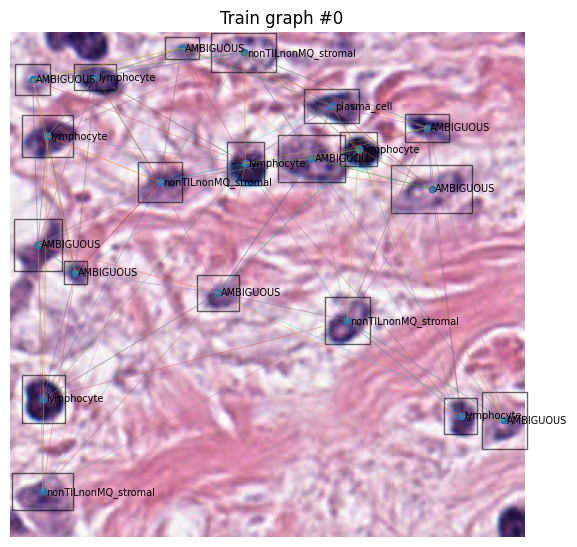

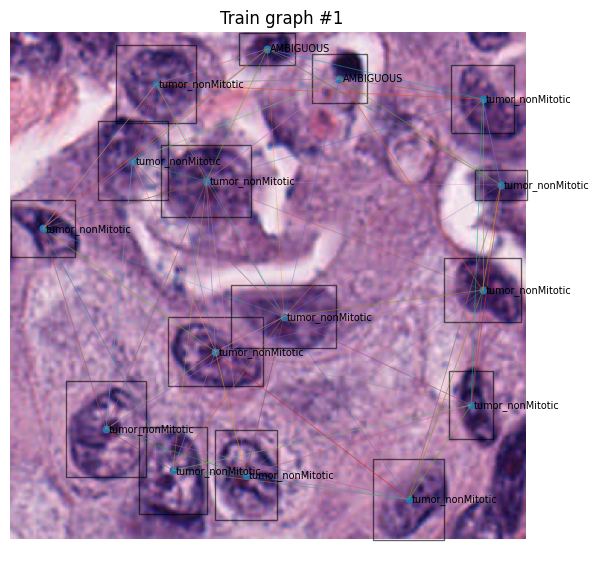

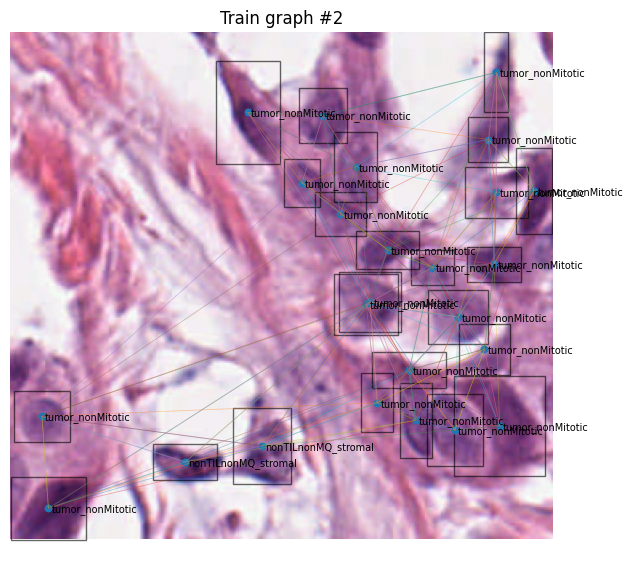

In [46]:
from torch_geometric.loader import DataLoader

label2id = build_label_map_from_pairs(train_pairs)  # from TRAIN fold
id2label = {v:k for k,v in label2id.items()}
num_classes = len(label2id)

train_ds = PatchGraphDataset(train_pairs, label2id=label2id)
test_ds  = PatchGraphDataset(test_pairs,  label2id=label2id)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)   # batch_size=1 makes drawing easy
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)

print("num_classes:", num_classes)
print("classes:", id2label)

# Draw first 3 training graphs
for i, data in enumerate(train_loader):
    if i >= 3: break
    # because batch_size=1, PyG still returns a Data object; edges/nodes belong to that single graph
    visualize_graph(data, id2label=id2label, draw_boxes=True, title=f"Train graph #{i}")


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch_geometric.nn import SAGEConv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNEncoder(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.proj = nn.Linear(512, emb_dim)

    def forward(self, x_img):
        h = self.backbone(x_img).flatten(1)
        return self.proj(h)

class GNN(nn.Module):
    def __init__(self, emb_dim=128, hidden=128, num_classes=8):
        super().__init__()
        self.c1 = SAGEConv(emb_dim, hidden)
        self.c2 = SAGEConv(hidden, hidden)
        self.c3 = SAGEConv(hidden, hidden)
        self.head = nn.Linear(hidden, num_classes)

    def forward(self, z, edge_index):
        h = F.relu(self.c1(z, edge_index))
        h = F.relu(self.c2(h, edge_index))
        h = F.relu(self.c3(h, edge_index))
        return self.head(h)

class CNN_GNN(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.enc = CNNEncoder(emb_dim=emb_dim)
        self.gnn = GNN(emb_dim=emb_dim, hidden=emb_dim, num_classes=num_classes)

    def forward(self, data):
        z = self.enc(data.x_img)
        logits = self.gnn(z, data.edge_index)
        return logits, z

model = CNN_GNN(emb_dim=128, num_classes=num_classes).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_correct, total_nodes = 0.0, 0, 0

    for data in loader:
        data = data.to(device)
        if data.y.numel() == 0:
            continue

        logits, _ = model(data)
        loss = F.cross_entropy(logits, data.y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += float(loss.item()) * data.y.numel()
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum().item())
        total_nodes += int(data.y.numel())

    return total_loss / max(1,total_nodes), total_correct / max(1,total_nodes)

# Use batch_size=2+ for speed during training (no drawing)
train_loader_fast = DataLoader(train_ds, batch_size=2, shuffle=True)
test_loader_fast  = DataLoader(test_ds,  batch_size=2, shuffle=False)

for epoch in range(1, 21):
    tr_loss, tr_acc = run_epoch(train_loader_fast, train=True)
    te_loss, te_acc = run_epoch(test_loader_fast,  train=False)
    print(f"epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")


epoch 01 | train loss 1.3321 acc 0.530 | test loss 1.4345 acc 0.465
epoch 02 | train loss 1.1507 acc 0.596 | test loss 1.1089 acc 0.623
epoch 03 | train loss 1.0863 acc 0.618 | test loss 1.1541 acc 0.610
epoch 04 | train loss 1.0469 acc 0.625 | test loss 1.1229 acc 0.589
epoch 05 | train loss 1.0153 acc 0.640 | test loss 1.0805 acc 0.622
epoch 06 | train loss 0.9643 acc 0.658 | test loss 1.3312 acc 0.542
epoch 07 | train loss 0.9105 acc 0.672 | test loss 1.0349 acc 0.634
epoch 08 | train loss 0.8529 acc 0.692 | test loss 1.2532 acc 0.575
epoch 09 | train loss 0.8012 acc 0.707 | test loss 1.0450 acc 0.639
epoch 10 | train loss 0.7684 acc 0.716 | test loss 1.0929 acc 0.612
epoch 11 | train loss 0.7219 acc 0.734 | test loss 1.0514 acc 0.647
epoch 12 | train loss 0.6502 acc 0.761 | test loss 1.1664 acc 0.603
epoch 13 | train loss 0.6190 acc 0.780 | test loss 1.3909 acc 0.541
epoch 14 | train loss 0.5448 acc 0.804 | test loss 1.1690 acc 0.605
epoch 15 | train loss 0.4835 acc 0.830 | test lo

In [49]:
import matplotlib.pyplot as plt
from PIL import Image

def _unwrap(x):
    return x[0] if isinstance(x, (list, tuple)) else x

def visualize_pred_graph(data, pred, id2label, max_edges=4000, title=None):
    rgb_path = _unwrap(data.rgb_path)
    img = Image.open(rgb_path).convert("RGB")

    pos = data.pos.cpu().numpy()
    edge_index = data.edge_index.cpu().numpy()
    pred_np = pred.cpu().numpy()

    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis("off")

    E = edge_index.shape[1]
    E_draw = min(E, max_edges)
    for e in range(E_draw):
        i = edge_index[0, e]
        j = edge_index[1, e]
        x1, y1 = pos[i]
        x2, y2 = pos[j]
        plt.plot([x1, x2], [y1, y2], linewidth=0.6, alpha=0.25)

    plt.scatter(pos[:,0], pos[:,1], s=30, c=pred_np)

    for i, (x, yv) in enumerate(pos):
        plt.text(x+2, yv+2, id2label[int(pred_np[i])], fontsize=7)

    plt.title(title or "Predicted graph")
    plt.show()


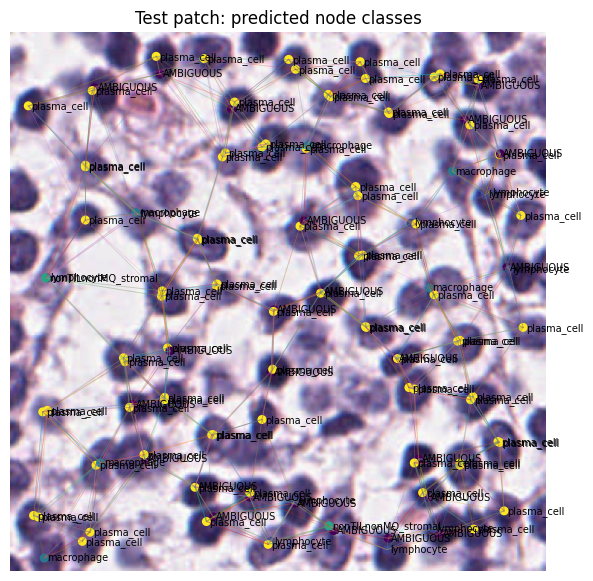

In [50]:
from torch_geometric.loader import DataLoader
import torch

model.eval()
data = next(iter(DataLoader(test_ds, batch_size=1, shuffle=True))).to(device)

with torch.no_grad():
    logits, _ = model(data)
    pred = logits.argmax(dim=1)

visualize_pred_graph(data.cpu(), pred.cpu(), id2label=id2label, title="Test patch: predicted node classes")


In [53]:
import torch
from sklearn.metrics import classification_report

model.eval()
all_true, all_pred = [], []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)            # <-- THIS LINE FIXES IT
        if data.y.numel() == 0:
            continue

        logits, _ = model(data)
        pred = logits.argmax(dim=1)

        all_true.append(data.y.cpu())
        all_pred.append(pred.cpu())

y_true = torch.cat(all_true).numpy()
y_pred = torch.cat(all_pred).numpy()

labels = list(range(num_classes))

print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=[train_ds.id2label[i] for i in labels],
    zero_division=0
))


import torch
from sklearn.metrics import confusion_matrix
import numpy as np



with torch.no_grad():
    for data in test_loader:
        data = data.to(device)        # IMPORTANT
        if data.y.numel() == 0:
            continue

        logits, _ = model(data)
        pred = logits.argmax(dim=1)

        all_true.append(data.y.cpu())
        all_pred.append(pred.cpu())

y_true = torch.cat(all_true).numpy()
y_pred = torch.cat(all_pred).numpy()


                     precision    recall  f1-score   support

          AMBIGUOUS       0.31      0.36      0.33      1549
         lymphocyte       0.79      0.39      0.52      3585
         macrophage       0.17      0.16      0.17       246
nonTILnonMQ_stromal       0.47      0.54      0.50      1312
      other_nucleus       0.11      0.11      0.11       122
        plasma_cell       0.25      0.59      0.35       955
      tumor_mitotic       0.27      0.23      0.25        13
   tumor_nonMitotic       0.78      0.80      0.79      2377

           accuracy                           0.51     10159
          macro avg       0.39      0.40      0.38     10159
       weighted avg       0.60      0.51      0.52     10159



In [54]:
labels = list(range(num_classes))  # force all classes

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels
)

print("Confusion matrix (rows=true, cols=pred):")
print(cm)


Confusion matrix (rows=true, cols=pred):
[[1128  198   62  704   20  468    8  510]
 [1524 2768   96  282    4 2362    2  132]
 [  66   20   78   74   10  184    0   60]
 [ 316  124  108 1410  120  224    2  320]
 [  54   26   12   28   28   96    0    0]
 [ 204  320   48  130   38 1130    0   40]
 [   2    0    0    0    0    0    6   18]
 [ 356   42   44  368   34   82    4 3824]]


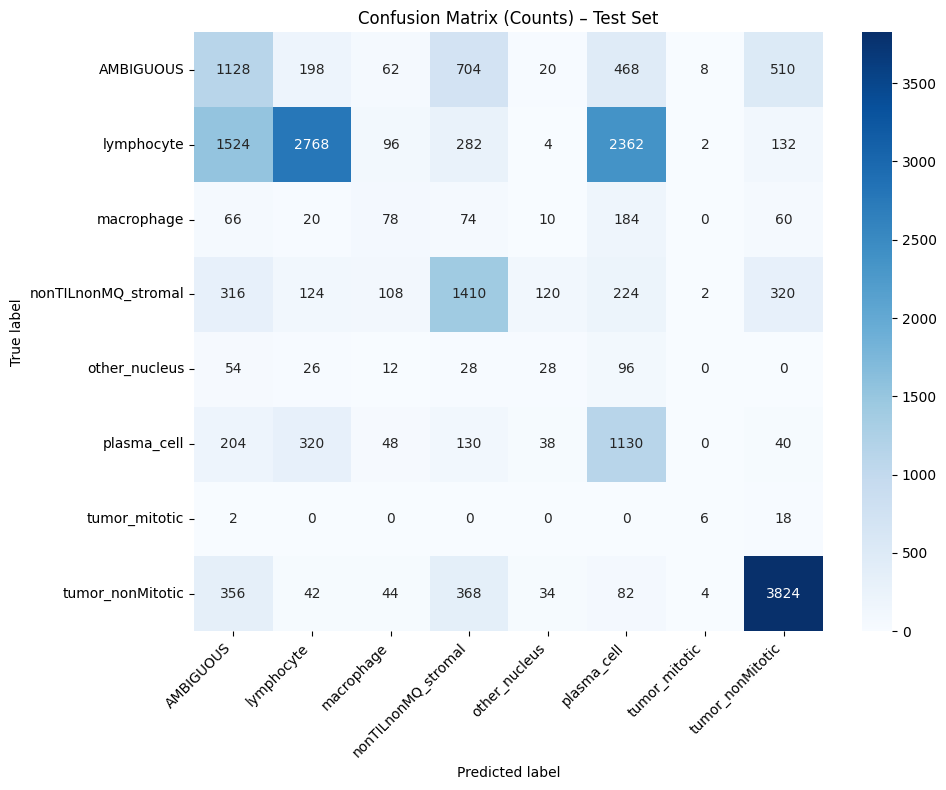

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



class_names = [
    "AMBIGUOUS",
    "lymphocyte",
    "macrophage",
    "nonTILnonMQ_stromal",
    "other_nucleus",
    "plasma_cell",
    "tumor_mitotic",
    "tumor_nonMitotic",
]

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Counts) – Test Set")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


model has learned strong signals for major phenotypes (tumor_nonMitotic, lymphocyte, stromal)

Errors mostly occur between biologically similar classes

Rare classes (tumor_mitotic, macrophage) are data-limited, not model-limited

In [ ]:
import imageio.v2 as imageio
import pandas as pd
import numpy as np

img = imageio.imread(RGB_PATH)[...,:3]
df  = pd.read_csv(CSV_PATH)

print(img.shape)
print(df.columns)
print(df["raw_classification"].value_counts())


(278, 279, 3)
Index(['Unnamed: 0', 'raw_classification', 'main_classification',
       'super_classification', 'type', 'xmin', 'ymin', 'xmax', 'ymax',
       'coords_x', 'coords_y'],
      dtype='object')
raw_classification
tumor             35
apoptotic_body     2
unlabeled          1
Name: count, dtype: int64


In [ ]:
LABEL_MAP = {
    "tumor": 0,
    "apopt": 1,
    "apoptotic_body": 1,
    "unlab": 2,
    "unlabeled": 2,
}

xs, ys, feats, labels = [], [], [], []

for _, r in df.iterrows():
    lab = r["raw_classification"]
    if lab not in LABEL_MAP:
        continue

    xmin, ymin, xmax, ymax = map(int, [r.xmin, r.ymin, r.xmax, r.ymax])
    patch = img[ymin:ymax, xmin:xmax]

    if patch.size == 0:
        continue

    mean_rgb = patch.reshape(-1,3).mean(axis=0)

    xs.append((xmin + xmax) / 2)
    ys.append((ymin + ymax) / 2)
    feats.append(mean_rgb)
    labels.append(LABEL_MAP[lab])

x = np.array(feats, dtype=np.float32)
pos = np.column_stack([xs, ys]).astype(np.float32)
y = np.array(labels, dtype=np.int64)

print("Nodes:", len(y))


Nodes: 38


In [ ]:
from sklearn.neighbors import NearestNeighbors

def knn_edges(pos, k=6):
    k = min(k+1, len(pos))
    nn = NearestNeighbors(n_neighbors=k).fit(pos)
    _, idx = nn.kneighbors(pos)
    src = np.repeat(np.arange(len(pos)), k-1)
    dst = idx[:,1:].reshape(-1)
    ei = np.vstack([src, dst])
    ei = np.hstack([ei, ei[::-1]])  # undirected
    return ei

edge_index = knn_edges(pos, k=6)


In [ ]:
import torch
from torch_geometric.data import Data

# normalize features
x = (x - x.mean(0)) / (x.std(0) + 1e-6)

data = Data(
    x=torch.tensor(x, dtype=torch.float),
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long),
)

print(data)


Data(x=[38, 3], edge_index=[2, 456], y=[38])


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class TinyGNN(torch.nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.conv = SAGEConv(in_dim, 32)
        self.lin  = torch.nn.Linear(32, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv(x, edge_index))
        return self.lin(x)

model = TinyGNN(data.x.shape[1], len(np.unique(y)))
opt = torch.optim.Adam(model.parameters(), lr=1e-2)


In [ ]:
for epoch in range(1, 201):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        pred = out.argmax(dim=1)
        acc = (pred == data.y).float().mean().item()
        print(f"epoch {epoch:3d} | loss {loss:.4f} | acc {acc:.3f}")


epoch   1 | loss 1.1713 | acc 0.053
epoch  20 | loss 0.2814 | acc 0.921
epoch  40 | loss 0.1978 | acc 0.921
epoch  60 | loss 0.1466 | acc 0.921
epoch  80 | loss 0.1114 | acc 0.974
epoch 100 | loss 0.0825 | acc 0.974
epoch 120 | loss 0.0612 | acc 0.974
epoch 140 | loss 0.0461 | acc 1.000
epoch 160 | loss 0.0350 | acc 1.000
epoch 180 | loss 0.0270 | acc 1.000
epoch 200 | loss 0.0212 | acc 1.000


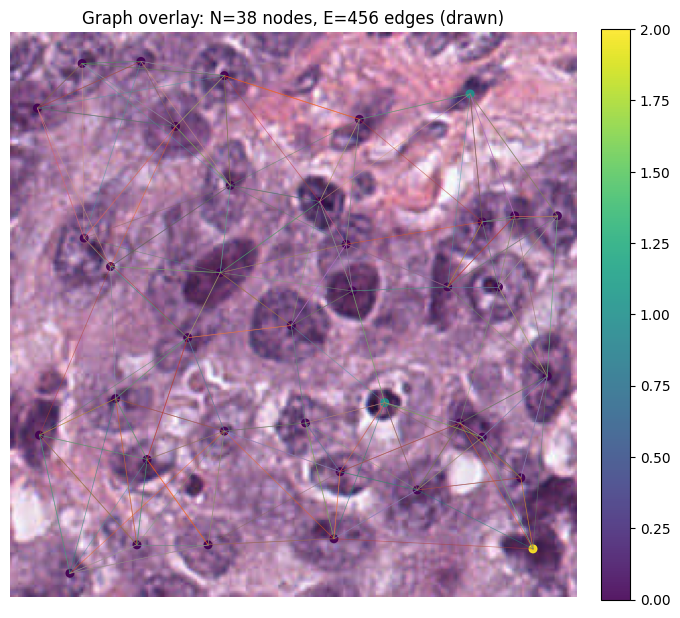

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_graph_on_image(img, pos, y, edge_index, max_edges_to_draw=1500, node_size=30):
    """
    img: HxWx3 uint8
    pos: [N,2] float32 (x,y)
    y:   [N] int labels
    edge_index: [2,E] int64 (source,dest)
    """

    H, W = img.shape[:2]
    pos = np.asarray(pos)
    y = np.asarray(y)
    ei = np.asarray(edge_index)

    # optionally downsample edges (so it's not a black blob)
    E = ei.shape[1]
    if E > max_edges_to_draw:
        keep = np.random.choice(E, size=max_edges_to_draw, replace=False)
        ei = ei[:, keep]

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

    # draw edges
    xs = pos[:, 0]; ys = pos[:, 1]
    for s, t in ei.T:
        plt.plot([xs[s], xs[t]], [ys[s], ys[t]], linewidth=0.5, alpha=0.35)

    # draw nodes (matplotlib will choose default colormap)
    sc = plt.scatter(xs, ys, c=y, s=node_size, alpha=0.9)

    # legend-ish colorbar
    plt.colorbar(sc, fraction=0.046, pad=0.04)
    plt.title(f"Graph overlay: N={len(pos)} nodes, E={ei.shape[1]} edges (drawn)")
    plt.show()

# If your pos is (x,y) and edge_index is shape [2,E]
plot_graph_on_image(img, pos, y, edge_index)


In [ ]:
import glob

def collect_patch_triplets(slide_names):
    samples = []
    for slide in slide_names:
        rgb_files = glob.glob(os.path.join(RGB_DIR, f"{slide}_*.png"))
        for rgb_path in rgb_files:
            base = os.path.splitext(os.path.basename(rgb_path))[0]
            mask_path = os.path.join(MASK_DIR, base + ".png")
            ann_path  = os.path.join(CSV_DIR,  base + ".csv")

            if os.path.exists(mask_path) and os.path.exists(ann_path):
                samples.append((rgb_path, mask_path, ann_path))
    return samples


In [ ]:
import pandas as pd
import os

FOLD = 4

train_split = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_train.csv"))
test_split  = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_test.csv"))

# IMPORTANT: slide-level split
train_slides = train_split["slide_name"].astype(str).tolist()
test_slides  = test_split["slide_name"].astype(str).tolist()

print("Train slides:", len(train_slides))
print("Test slides :", len(test_slides))
print("Example train slide:", train_slides[0])


Train slides: 99
Test slides : 25
Example train slide: TCGA-BH-A0BL-DX1


In [ ]:
train_samples = collect_patch_triplets(train_slides)
test_samples  = collect_patch_triplets(test_slides)

print("Train patches:", len(train_samples))
print("Test patches :", len(test_samples))

# show one example to verify paths
train_samples[0]


Train patches: 1450
Test patches : 294


('/content/drive/MyDrive/QC/rgb/TCGA-BH-A0BL-DX1_id-5ea40977ddda5f839897c4d8_left-28546_top-44875_bottom-45156_right-28831.png',
 '/content/drive/MyDrive/QC/mask/TCGA-BH-A0BL-DX1_id-5ea40977ddda5f839897c4d8_left-28546_top-44875_bottom-45156_right-28831.png',
 '/content/drive/MyDrive/QC/csv/TCGA-BH-A0BL-DX1_id-5ea40977ddda5f839897c4d8_left-28546_top-44875_bottom-45156_right-28831.csv')

In [ ]:
print("RGB files example:", os.listdir(RGB_DIR)[:5])


RGB files example: ['TCGA-AR-A0U4-DX1_id-5ea40a88ddda5f8398990ccf_left-41899_top-70539_bottom-70809_right-42169.png', 'TCGA-AR-A0U4-DX1_id-5ea40a88ddda5f8398990ccf_left-41880_top-70798_bottom-71087_right-42167.png', 'TCGA-AR-A0U4-DX1_id-5ea40a88ddda5f8398990ccf_left-46768_top-71058_bottom-71332_right-47039.png', 'TCGA-AR-A1AQ-DX1_id-5ea4097addda5f839897cb65_left-19432_top-40082_bottom-40344_right-19719.png', 'TCGA-AR-A1AQ-DX1_id-5ea4097addda5f839897cb65_left-20459_top-40847_bottom-41125_right-20763.png']


In [ ]:
DEBUG = True
if DEBUG:
    train_samples = train_samples[:5]
    test_samples  = test_samples[:2]

print("Using:", len(train_samples), "train |", len(test_samples), "test")


Using: 5 train | 2 test


In [ ]:
train_graphs = build_graphs(train_samples)
test_graphs  = build_graphs(test_samples)

print("Graphs built:", len(train_graphs), "train |", len(test_graphs), "test")
print("Nodes in first train graph:", train_graphs[0].num_nodes)


Graphs built: 1 train | 0 test
Nodes in first train graph: 3


In [ ]:
import pandas as pd
import os

FOLD = 4


train_split = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_train.csv"))
test_split  = pd.read_csv(os.path.join(SPLIT_DIR, f"fold_{FOLD}_test.csv"))

def get_id_list(df):
    # Use first column if not sure
    col = df.columns[0]
    return df[col].astype(str).tolist()

train_ids = get_id_list(train_split)
test_ids  = get_id_list(test_split)

print(f"Train samples: {len(train_ids)}")
print(f"Test samples:  {len(test_ids)}")


train_ids, test_ids


Train samples: 99
Test samples:  25


(['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '90',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',
  '97',
  '98'],
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24'])

In [ ]:
print("Num train IDs:", len(train_ids))
print("First 5 train IDs:", train_ids[:5])

train_samples, train_missing = build_samples(train_ids)
test_samples, test_missing = build_samples(test_ids)

print("Resolved train triplets:", len(train_samples), " Missing:", len(train_missing))
print("Resolved test  triplets:", len(test_samples),  " Missing:", len(test_missing))

# Show a few missing examples (this usually reveals the naming mismatch)
for m in train_missing[:5]:
    sid, rgb, mask, ann = m
    print("MISSING:", sid)
    print("  rgb :", rgb)
    print("  mask:", mask)
    print("  ann :", ann)


Num train IDs: 99
First 5 train IDs: ['0', '1', '2', '3', '4']
Resolved train triplets: 0  Missing: 99
Resolved test  triplets: 0  Missing: 25
MISSING: 0
  rgb : None
  mask: None
  ann : None
MISSING: 1
  rgb : None
  mask: None
  ann : None
MISSING: 2
  rgb : None
  mask: None
  ann : None
MISSING: 3
  rgb : None
  mask: None
  ann : None
MISSING: 4
  rgb : None
  mask: None
  ann : None


In [ ]:
import glob

def find_one(patterns):
    for p in patterns:
        hits = glob.glob(p)
        if hits:
            return hits[0]
    return None

def resolve_paths(sample_id):
    # strip extension if present
    base = os.path.splitext(os.path.basename(sample_id))[0]

    rgb  = find_one([f"{RGB_DIR}/{base}.*"])
    mask = find_one([f"{MASK_DIR}/{base}.*"])
    ann  = find_one([f"{CSV_DIR}/{base}*.csv", f"{CSV_DIR}/{base}.csv"])

    return rgb, mask, ann

def build_samples(id_list):
    samples = []
    missing = []
    for sid in id_list:
        rgb, mask, ann = resolve_paths(sid)
        if (rgb is None) or (mask is None) or (ann is None):
            missing.append((sid, rgb, mask, ann))
        else:
            samples.append((rgb, mask, ann))
    return samples, missing

train_samples, train_missing = build_samples(train_ids)
test_samples,  test_missing  = build_samples(test_ids)

print("Train samples:", len(train_samples), "missing:", len(train_missing))
print("Test  samples:", len(test_samples),  "missing:", len(test_missing))
train_missing[:3]


Train samples: 0 missing: 99
Test  samples: 0 missing: 25


[('0', None, None, None), ('1', None, None, None), ('2', None, None, None)]

In [ ]:
!pip -q install torch-geometric scikit-image scikit-learn imageio pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import imageio.v2 as imageio

from skimage.measure import label, regionprops
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv

# ---- tweak these for your label strings ----
LABEL_MAP = {
    "tumor": 0,
    "apopt": 1,            # if your CSV uses "apopt" not "apoptotic_body"
    "apoptotic_body": 1,   # keep both just in case
    "unlab": 2,
    "unlabeled": 2,
}

KNN_K = 8

def load_mask_instances(mask_path):
    m = imageio.imread(mask_path)
    if m.ndim == 2:
        return m.astype(np.int32)

    # RGB mask visualization fallback: threshold red-ish then CC-label
    r, g, b = m[...,0], m[...,1], m[...,2]
    fg = (r > 150) & (g < 130) & (b < 130)
    return label(fg).astype(np.int32)

def extract_nodes(rgb, inst):
    props = regionprops(inst)
    feats, centroids = [], []
    for p in props:
        if p.label == 0:
            continue
        rr, cc = p.coords[:,0], p.coords[:,1]
        area = float(p.area)
        pix = rgb[rr, cc, :3].astype(np.float32)
        mean_rgb = pix.mean(axis=0)
        feats.append([area, mean_rgb[0], mean_rgb[1], mean_rgb[2]])
        centroids.append([p.centroid[1], p.centroid[0]])  # x,y
    return np.asarray(feats, np.float32), np.asarray(centroids, np.float32)

def build_knn_edges(centroids, k=8):
    n = len(centroids)
    if n < 2:
        return np.zeros((2,0), dtype=np.int64)
    k_eff = min(k+1, n)
    nn = NearestNeighbors(n_neighbors=k_eff).fit(centroids)
    _, idx = nn.kneighbors(centroids)
    src = np.repeat(np.arange(n), k_eff-1)
    dst = idx[:,1:].reshape(-1)
    ei = np.vstack([src, dst]).astype(np.int64)
    ei = np.hstack([ei, ei[::-1]])  # undirected
    return ei

def assign_labels_from_ann(csv_path, centroids_xy):
    df = pd.read_csv(csv_path)

    # Expect bbox columns like xmin,ymin,xmax,ymax + raw_classification
    # If yours differ, print(df.columns) and adjust here.
    boxes = df[["xmin","ymin","xmax","ymax"]].to_numpy(np.float32)
    raw = df["raw_classification"].astype(str).tolist()

    y = np.full((len(centroids_xy),), -1, dtype=np.int64)
    for i,(x,yc) in enumerate(centroids_xy):
        assigned = False
        for (xmin,ymin,xmax,ymax), lab in zip(boxes, raw):
            if xmin <= x <= xmax and ymin <= yc <= ymax:
                if lab in LABEL_MAP:
                    y[i] = LABEL_MAP[lab]
                assigned = True
                break
        if not assigned:
            # default to unlabeled if available, else ignore
            y[i] = LABEL_MAP.get("unlabeled", -1)
    return y

def make_graph(rgb_path, mask_path, ann_path):
    rgb = imageio.imread(rgb_path)[...,:3]
    inst = load_mask_instances(mask_path)

    H = min(rgb.shape[0], inst.shape[0])
    W = min(rgb.shape[1], inst.shape[1])
    rgb, inst = rgb[:H,:W], inst[:H,:W]

    x, c = extract_nodes(rgb, inst)
    if x.shape[0] < 3:
        return None

    y = assign_labels_from_ann(ann_path, c)
    keep = y >= 0
    x, c, y = x[keep], c[keep], y[keep]
    if len(y) < 3:
        return None

    # normalize features
    x = (x - x.mean(0, keepdims=True)) / (x.std(0, keepdims=True) + 1e-6)

    edge_index = build_knn_edges(c, KNN_K)
    return Data(
        x=torch.tensor(x, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor(y, dtype=torch.long),
    )

class TinyCellGNN(torch.nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, 32)
        self.lin = torch.nn.Linear(32, num_classes)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.lin(x)

def build_graphs(sample_triplets):
    graphs = []
    for rgb_path, mask_path, ann_path in sample_triplets:
        g = make_graph(rgb_path, mask_path, ann_path)
        if g is not None:
            graphs.append(g)
    return graphs

train_graphs = build_graphs(train_samples)
test_graphs  = build_graphs(test_samples)

print("Graphs built:", len(train_graphs), "train |", len(test_graphs), "test")

num_classes = max(LABEL_MAP.values()) + 1
in_dim = train_graphs[0].x.shape[1]

model = TinyCellGNN(in_dim, num_classes)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_graphs, batch_size=1, shuffle=False)

def eval_loader(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            logits = model(batch.x, batch.edge_index)
            pred = logits.argmax(dim=-1)
            correct += int((pred == batch.y).sum())
            total += int(batch.y.numel())
    return correct / max(1,total)

for epoch in range(1, 101):
    model.train()
    for batch in train_loader:
        opt.zero_grad()
        logits = model(batch.x, batch.edge_index)
        loss = F.cross_entropy(logits, batch.y)
        loss.backward()
        opt.step()

    if epoch % 20 == 0 or epoch == 1:
        tr = eval_loader(train_loader)
        te = eval_loader(test_loader) if len(test_graphs)>0 else float("nan")
        print(f"epoch {epoch:3d} | train_acc {tr:.3f} | test_acc {te:.3f}")


Graphs built: 0 train | 0 test


IndexError: list index out of range

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from pathlib import Path

PATCH_SIZE = 64
HALF = PATCH_SIZE // 2

rgb_dir = Path("rgb")
mask_dir = Path("mask")
csv_dir = Path("csv")

records = []

for csv_file in csv_dir.glob("*.csv"):
    df = pd.read_csv(csv_file)

    img_id = csv_file.stem
    img = cv2.imread(str(rgb_dir / f"{img_id}.png"))[..., ::-1]
    mask = cv2.imread(str(mask_dir / f"{img_id}.png"), 0)

    props = regionprops(mask)

    for p in props:
        inst_id = p.label
        row = df[df["instance_id"] == inst_id]
        if len(row) == 0:
            continue

        y, x = map(int, p.centroid)
        y1, y2 = y - HALF, y + HALF
        x1, x2 = x - HALF, x + HALF

        if y1 < 0 or x1 < 0 or y2 > img.shape[0] or x2 > img.shape[1]:
            continue

        patch = img[y1:y2, x1:x2]
        label = int(row["label"].values[0])

        records.append({
            "patch": patch,
            "label": label,
            "image_id": img_id,
            "instance_id": inst_id
        })

print(f"Extracted {len(records)} nucleus patches")


In [ ]:
split_df = pd.read_csv("train_test_splits/split_0.csv")
train_ids = set(split_df[split_df.split == "train"].image_id)
test_ids  = set(split_df[split_df.split == "test"].image_id)

train_data = [r for r in records if r["image_id"] in train_ids]
test_data  = [r for r in records if r["image_id"] in test_ids]


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

class NucDataset(Dataset):
    def __init__(self, data, tfm):
        self.data = data
        self.tfm = tfm

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        img = Image.fromarray(self.data[i]["patch"])
        x = self.tfm(img)
        y = self.data[i]["label"]
        return x, y

tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
    transforms.ToTensor()
])

train_ds = NucDataset(train_data, tfm)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

model = models.resnet18(weights=None)
model.fc = nn.Linear(512, NUM_CLASSES)
model = model.cuda()

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()


In [ ]:
feature_model = models.resnet18(weights=None)
feature_model.load_state_dict(model.state_dict(), strict=False)
feature_model.fc = nn.Identity()
feature_model = feature_model.cuda().eval()


In [ ]:
@torch.no_grad()
def extract_features(data):
    feats, labels, meta = [], [], []
    for r in data:
        img = transforms.ToTensor()(Image.fromarray(r["patch"])).unsqueeze(0).cuda()
        f = feature_model(img).cpu().numpy()[0]
        feats.append(f)
        labels.append(r["label"])
        meta.append((r["image_id"], r["instance_id"]))
    return np.array(feats), np.array(labels), meta

X_train, y_train, meta_train = extract_features(train_data)
X_test,  y_test,  meta_test  = extract_features(test_data)

np.save("train_features.npy", X_train)
np.save("test_features.npy", X_test)
